In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
data_folder = "../testing_data"
prefix = "thrustData"
filenames = []
testnames = []
voltages = []
for filename in os.listdir(data_folder):
    if prefix in filename:
        filenames.append(data_folder+"/"+filename)
        testnames.append(filename.split("_")[1]+"_"+filename.split("_")[2])
        voltages.append(filename.split("_")[3].split(".txt")[0])

In [3]:
filenames

['../testing_data/thrustData_5x4.5x3_T01_11.62.txt',
 '../testing_data/thrustData_5x4.5x3_T02_11.57.txt',
 '../testing_data/thrustData_5x4.5x3_T03_11.30.txt',
 '../testing_data/thrustData_7x4x3_T01_10.93.txt',
 '../testing_data/thrustData_7x4x3_T02_11.11.txt',
 '../testing_data/thrustData_7x4x3_T03_12.43.txt',
 '../testing_data/thrustData_7x5x2_T01_11.33.txt',
 '../testing_data/thrustData_7x5x2_T02_11.19.txt',
 '../testing_data/thrustData_7x5x2_T03_11.08.txt']

In [4]:
testnames

['5x4.5x3_T01',
 '5x4.5x3_T02',
 '5x4.5x3_T03',
 '7x4x3_T01',
 '7x4x3_T02',
 '7x4x3_T03',
 '7x5x2_T01',
 '7x5x2_T02',
 '7x5x2_T03']

In [5]:
timestamp = {}
throttle = {}
thrust = {}
xfit = np.linspace(0,100,20)
thrustfit = {}

print("Max Thrust for each Test")
for filename,testname in zip(filenames,testnames):
    initTime = False
    firsttime = []
    with open(filename,'r') as f:     
        timestamp[testname] = []
        throttle[testname] = []
        thrust[testname] = []

        for line in f:
            if (not ("Throttle:" in  line)) and (not("Thrust:" in line)):
                continue
            else:
                thrustval = line.split("Thrust: ")[1].split(" grams")[0]
                if not thrustval=='':
                    throttle[testname].append(float(line.split("Throttle: ")[1].split("%")[0]))
                    thrust[testname].append(float(thrustval))
                    timestr = line.split(" ->")[0].split(":")
                    timestr = [float(x) for x in timestr]
                    if not initTime:
                        firsttime = timestr
                        initTime = True    
                    elapse = (timestr[0]-firsttime[0])*3600+(timestr[1]-firsttime[1])*60 +(timestr[2]-firsttime[2])
                    timestamp[testname].append(elapse)
        a,b,c = np.polyfit(throttle.get(testname),thrust.get(testname),2)
        thrustfit[testname] = a*xfit**2 + b*xfit + c
    
    print(testname+": "+str(max(thrust.get(testname))))
            

Max Thrust for each Test
5x4.5x3_T01: 553.839
5x4.5x3_T02: 576.942
5x4.5x3_T03: 568.555
7x4x3_T01: 975.574
7x4x3_T02: 976.61
7x4x3_T03: 1096.751
7x5x2_T01: 949.895
7x5x2_T02: 938.4
7x5x2_T03: 950.93


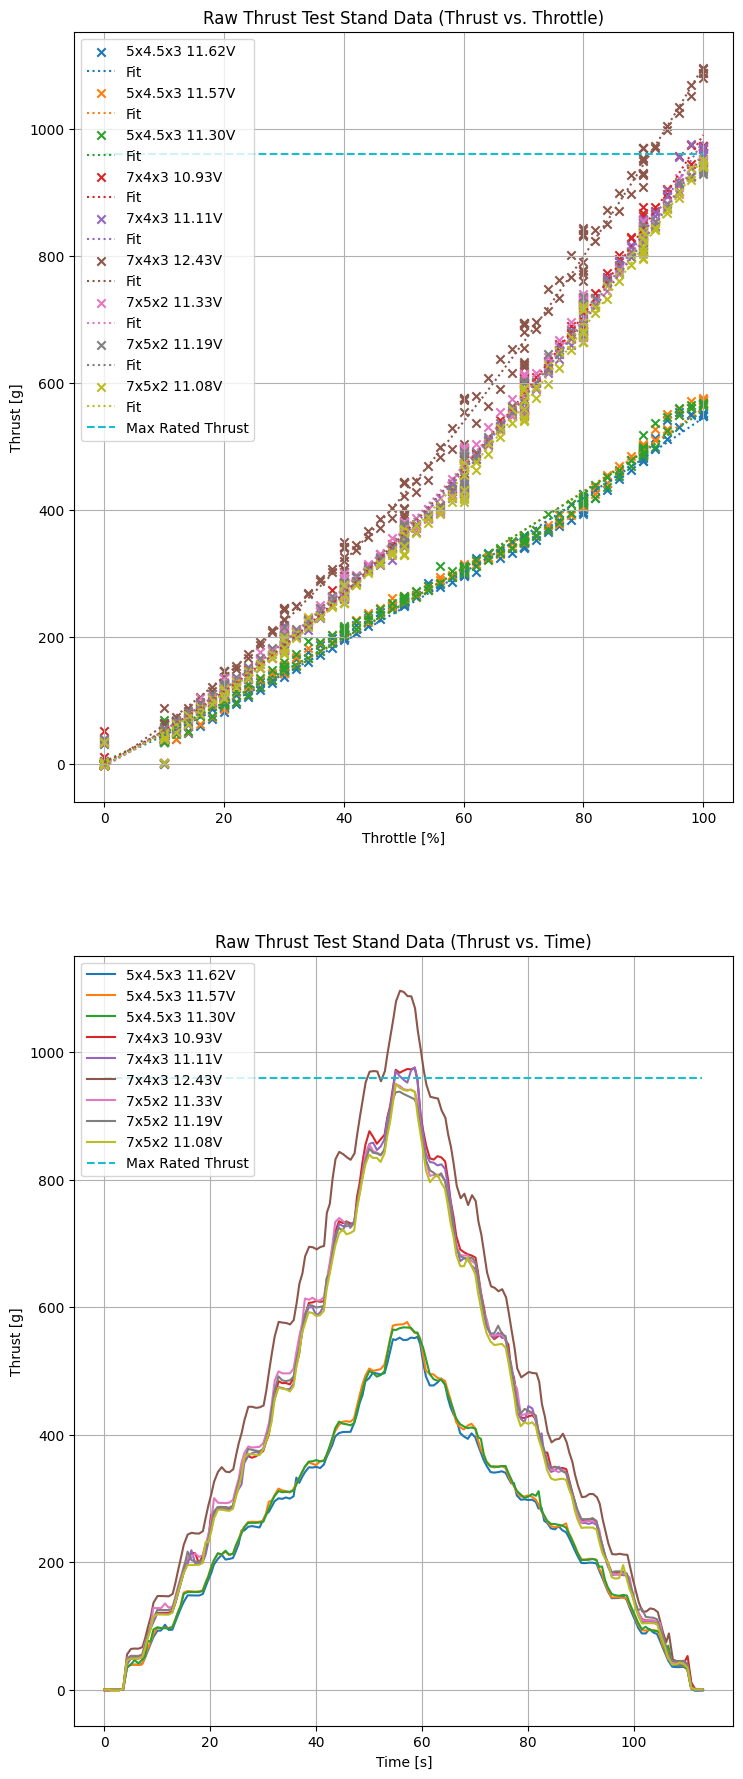

In [45]:
plt.figure(figsize=(8.5,22))
max_motor_pull = 960 # grams, as rated by manufacturer on amazon page: https://www.amazon.com/gp/product/B089YN9WM9/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&th=1 

# Raw Thrust Data Plot vs throttle
plt.subplot2grid((2,1),(0,0))
for filename,testname,voltage in zip(filenames,testnames,voltages):
    if "thrust" in filename: 
        plt.scatter(throttle.get(testname),thrust.get(testname),label=testname.split("_")[0]+" "+voltage+"V",marker="x")
        plt.plot(xfit,thrustfit.get(testname),label="Fit",linestyle=":")
plt.plot([0,100],[max_motor_pull,max_motor_pull],label="Max Rated Thrust",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Thrust [g]")
plt.grid()
plt.title("Raw Thrust Test Stand Data (Thrust vs. Throttle)")
plt.legend(loc="upper left")      


# Time based raw data
plt.subplot2grid((2,1),(1,0))
maxtimes = []
for filename,testname,voltage in zip(filenames,testnames,voltages):
    if "thrust" in filename:
        #dtpts = len(thrust.get(testname))
        #time = np.linspace(0,dtpts*0.2,dtpts)
        #maxtimes.append(time[-1])
        plt.plot(timestamp.get(testname),thrust.get(testname),label=testname.split("_")[0]+" "+voltage+"V")
plt.plot([0,max(timestamp.get(testname))],[max_motor_pull,max_motor_pull],label="Max Rated Thrust",linestyle="--")
plt.xlabel("Time [s]")
plt.ylabel("Thrust [g]")
plt.grid()
plt.title("Raw Thrust Test Stand Data (Thrust vs. Time)")
plt.legend(loc="upper left")
plt.savefig("../plots/Thrust_RawData")

In [46]:
powerfilename = "currentPowerData.csv"
throttle_pow = []
csvtestlst = testnames[0:3]+testnames[6:]+testnames[3:6]
current = {}
power = {}
currentfit = {}
powerfit = {}

for test in csvtestlst:
    current[test] = []
    power[test] = []

with open(data_folder+"/"+powerfilename,'r') as f:
    powdata = f.readlines()
    powdata = powdata[3:]

for row in powdata:
    sepdata = row.split(",")[:len(csvtestlst)*2+1]
    throttle_pow.append(float(sepdata[0]))
    i=1
    while i<len(csvtestlst)+1:
        power[csvtestlst[i-1]].append(float(sepdata[(i*2)]))
        current[csvtestlst[i-1]].append(float(sepdata[i*2-1]))
        i+=1
for test in csvtestlst:
    a,b,c = np.polyfit(throttle_pow,current.get(test),2)
    currentfit[test] = a*xfit**2 + b*xfit + c
    a,b,c = np.polyfit(throttle_pow,power.get(test),2)
    powerfit[test] = a*xfit**2 + b*xfit + c

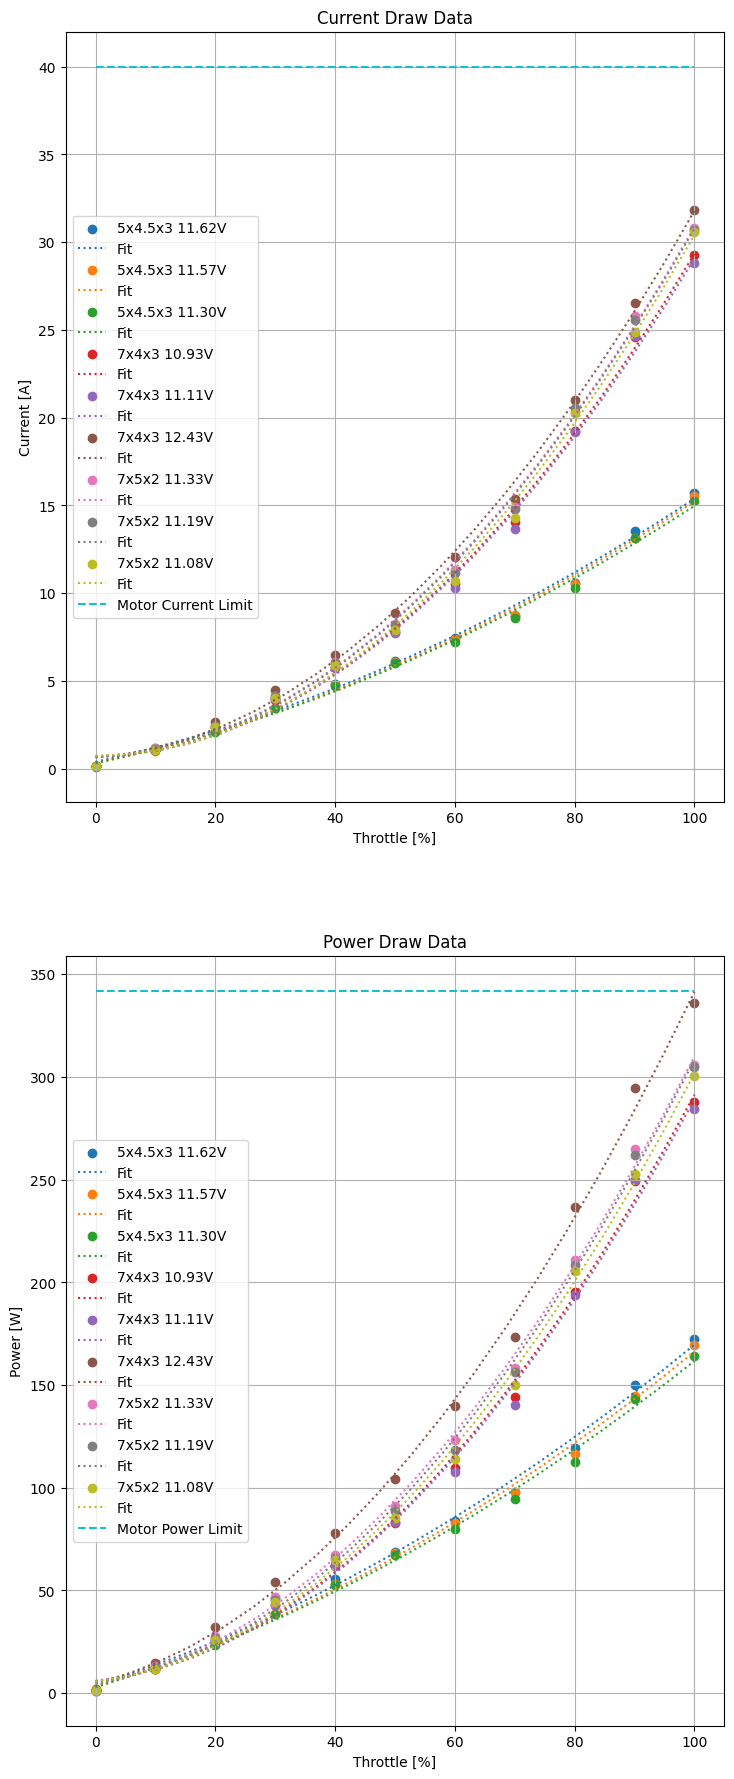

In [53]:
# Current/Power Data Plot
current_limit_motor = 40 # amps
power_limit_motor = 342 # W

plt.figure(figsize=(8.5,22))
plt.subplot(2,1,1)
for testname,voltage in zip(testnames,voltages):
    plt.scatter(throttle_pow,current.get(testname),label=testname.split("_")[0]+" "+voltage+"V")
    plt.plot(xfit,currentfit.get(testname),label="Fit",linestyle=":")
plt.plot([0,100],[current_limit_motor,current_limit_motor],label="Motor Current Limit",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Current [A]")
plt.grid()
plt.legend()
plt.title("Current Draw Data")

plt.subplot(2,1,2)
for testname,voltage in zip(testnames,voltages):
    plt.scatter(throttle_pow,power.get(testname),label=testname.split("_")[0]+" "+voltage+"V")
    plt.plot(xfit,powerfit.get(testname),label="Fit",linestyle=":")
plt.plot([0,100],[power_limit_motor,power_limit_motor],label="Motor Power Limit",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Power [W]")
plt.grid()
plt.legend()
plt.title("Power Draw Data")
plt.savefig("../plots/CurrentPower_RawData")

In [49]:
# averaged data
avgthrust = {}
for testname in testnames:
    avgthrust[testname] = []
    oldthrottle = 0
    interimthrust = []
    for x,y in zip(throttle.get(testname),thrust.get(testname)):
        if not (x%10==0):
            continue
        elif oldthrottle==x:
            interimthrust.append(y)
            oldthrottle=x
        else:
            avgthrust[testname].append(np.average(interimthrust))
            interimthrust = []
            interimthrust.append(y)
            oldthrottle=x

for test in testnames:
    fhalf = np.array(avgthrust[test][1:10])
    lhalf = np.flip(np.array(avgthrust[test][11:]))
    mid = np.array(avgthrust[test][10])
    zero = np.array([0])
    avgthrust[test] = np.hstack((zero,np.mean(np.vstack((fhalf,lhalf)),0),mid))

In [50]:
#avgthrust has 11 data points from 0-100 throttle with thrust value for each 10% position
#we also have current and power data for corresponding tests and throttles, so we can 
# get ratios of thrust/power and thrust/current
thrust_per_amp = {}
thrust_per_watt = {}
for test in testnames:
    thrust_per_amp[test] = avgthrust[test]/current[test]
    thrust_per_watt[test] = avgthrust[test]/power[test]

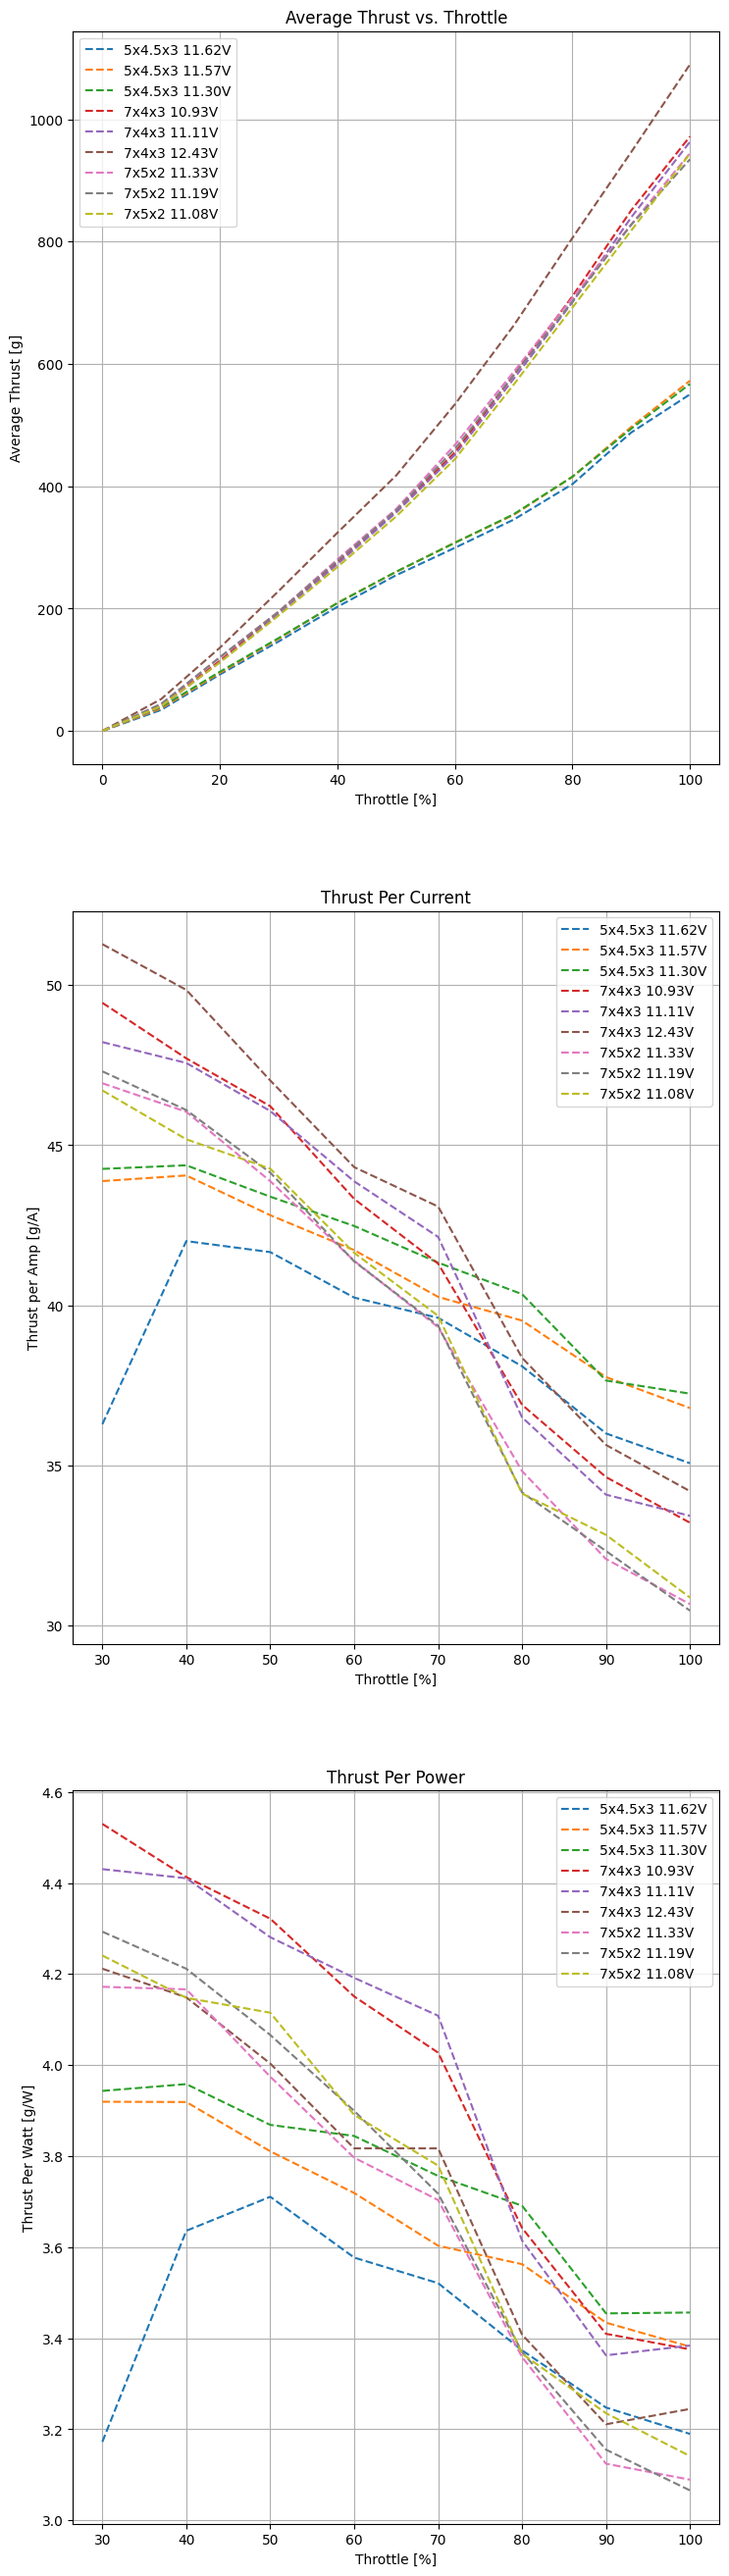

In [52]:
#average thrust plot
plt.figure(figsize=(8.5,33))

plt.subplot(3,1,1)
for test,voltage in zip(testnames,voltages):
    plt.plot(throttle_pow,avgthrust[test],label=test.split("_")[0]+" "+voltage+"V",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Average Thrust [g]")
plt.title("Average Thrust vs. Throttle")
plt.legend()
plt.grid()

plt.subplot(3,1,2)
for test,voltage in zip(testnames,voltages):
    plt.plot(throttle_pow[3:],thrust_per_amp[test][3:],label=test.split("_")[0]+" "+voltage+"V",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Thrust per Amp [g/A]")
plt.title("Thrust Per Current")
plt.legend()
plt.grid()

plt.subplot(3,1,3)
for test,voltage in zip(testnames,voltages):
    plt.plot(throttle_pow[3:],thrust_per_watt[test][3:],label=test.split("_")[0]+" "+voltage+"V",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Thrust Per Watt [g/W]")
plt.title("Thrust Per Power")
plt.legend()
plt.grid()

plt.savefig("../plots/AvgThrust_Efficiency_Data")